# Initialization

Test notebook for the damadics benchmark. Approach using anomaly detection techniques. 

First we import the necessary packages and create the global variables.

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib
import seaborn as sns
import pandas as pd
import logging
import random
import plottingTools
from datetime import datetime
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
from dataManagement import DataManagerDamadics

from IPython.display import display, HTML
%matplotlib notebook

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("damadics")
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler("DataManager.log")
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

random_seed = 0 #Change this to make it really random, 0 for testing purposes
random.seed(random_seed)

'''columnArrangement = ['id', 'selectedFault', 'faultType', 'faultIntensity', 'externalControllerOutput', 'disturbedMediumFlow', 
                        'pressureValveInlet', 'pressureValveOutlet', 'undisturbedMediumFlow', 'mediumTemperature', 'rodDisplacement']'''

columnArrangement = ['id', 'selectedFault', 'faultType', 'faultIntensity', 'externalControllerOutput', 'disturbedMediumFlow', 
                        'pressureValveInlet', 'pressureValveOutlet', 'mediumTemperature', 'rodDisplacement']

desiredComponents = ["Valve"]
dataManager = DataManagerDamadics(user="readOnly", password="readOnly", engineType="mysql+mysqldb://", dbName="damadics2", host="localhost", port="3306")

classifiers = {'DummyClf':DummyClassifier(), 'EllipticEnvelope':EllipticEnvelope(contamination=0.2), 
               'MLP':MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(10,10,5), random_state=random_seed)}

y_trains = {'DummyClf':None, 'EllipticEnvelope':list(), 'MLP':None}
y_tests = {'DummyClf':None, 'EllipticEnvelope':list(), 'MLP':None}

pd.options.mode.chained_assignment = None
nsamples = 1000
scoringMetrics = ['precision_macro', 'recall_macro', 'f1_macro']
cv_folds = 4

DEBUG:damadics.dataManagement:Connection to mysql+mysqldb://localhost:3306/damadics2 successfull


# Reshaping the data

We need to reshape the data we get from the database. This reshaping is done in order to get X and y vectors
that can be used for the training of the models.

In [2]:
def retrieve_and_reshape_data(startDateTime = None, endDateTime = None, desiredComponents = None):
    """Gets the data and reshapes it to give me X and y as per machine learning standards.
    For the labels, 0 means normal and 1 means faulty."""

    dataFrames = dataManager.readData(startDateTime, endDateTime, desiredComponents)
    
    features = ['disturbedMediumFlow', 'pressureValveInlet', 'pressureValveOutlet', 
                'mediumTemperature', 'rodDisplacement', 'externalControllerOutput']
    
    df = dataFrames['ValveReadings']
    df = dataManager.reshapeAndCleanDataFrame(df)
    df = df[columnArrangement] #Rearrange columns
    
    #display(df.head())
    
    X = df[features].values
    #X = X.T
    
    selectedFault = df['selectedFault'].values
    selectedFault = (selectedFault != 20) #20, in the database, is given to normal observations
    y = selectedFault.astype(int)
    y = np.reshape(y, (y.shape[0], 1))
    #y = y.T
    
    return X, y, df

# Retrieve data

We retrieve the data needed for our models. We specify the start and end dates for the data we want to use.

In [7]:
startDateTime = datetime(2017, 12, 30, hour=0, minute=0, second=0, microsecond=0)
endDateTime = datetime(2018, 1, 28, hour=0, minute=0, second=0, microsecond=0)

train_size = 0.9
test_size = 1-train_size

#0 means normal and 1 means fault
X, y, df = retrieve_and_reshape_data(startDateTime, endDateTime, desiredComponents)

#Standardize the data
X_transformed = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, train_size = train_size, 
                                                    test_size = test_size, random_state=random_seed)

#Generate useful counts
n_m, n_x = X.shape #Number of samples, features
train_n_m, train_n_x = X_train.shape #Number of samples, features for training
test_n_m, test_n_x = X_test.shape #Number of samples, features for testing
fault_count = np.count_nonzero(y)
non_fault_count = n_m - fault_count
fault_nofault_Ratio = fault_count/non_fault_count

print('\nTotal sample size {}, Train Size {} ({}%), Test Size {} ({}%)'.format(n_m, X_train.shape[0], np.round(train_size*100),  
                                                                               X_test.shape[0], np.round(test_size*100)))

print('Total sample size {}, Faulty samples {}, Normal samples {}, Fault/Non Fault Ratio {:.4f}'.
      format(n_m, fault_count, non_fault_count, fault_nofault_Ratio))

display(df.head())

DEBUG:damadics.dataManagement:Loading data for components [<class 'damadicsDBMapping.ValveReading'>] from 2017-12-30 00:00:00 to 2018-01-28 00:00:00



Total sample size 41121, Train Size 37008 (90.0%), Test Size 4113 (10.0%)
Total sample size 41121, Faulty samples 6256, Normal samples 34865, Fault/Non Fault Ratio 0.1794


,id,selectedFault,faultType,faultIntensity,externalControllerOutput,disturbedMediumFlow,pressureValveInlet,pressureValveOutlet,mediumTemperature,rodDisplacement
timestamp,,,,,,,,,,
2017-12-30 10:39:58,1,20,1,0.0,0.500000,1.000000,0.876840,0.650832,0.214553,0.001590
2017-12-30 10:40:58,2,20,1,0.0,0.366043,1.000000,0.850576,0.643717,0.215373,0.369939
2017-12-30 10:41:58,3,20,1,0.0,0.732444,0.222181,0.849537,0.647472,0.214781,0.732446
2017-12-30 10:42:58,4,20,1,0.0,0.257854,0.997590,0.849203,0.648064,0.214384,0.239649
2017-12-30 10:43:58,5,20,1,0.0,0.659356,0.283687,0.848475,0.654271,0.214159,0.675030


# Generate some plots

We now generate some useful plots to gain some insight on the data.

<IPython.core.display.Javascript object>


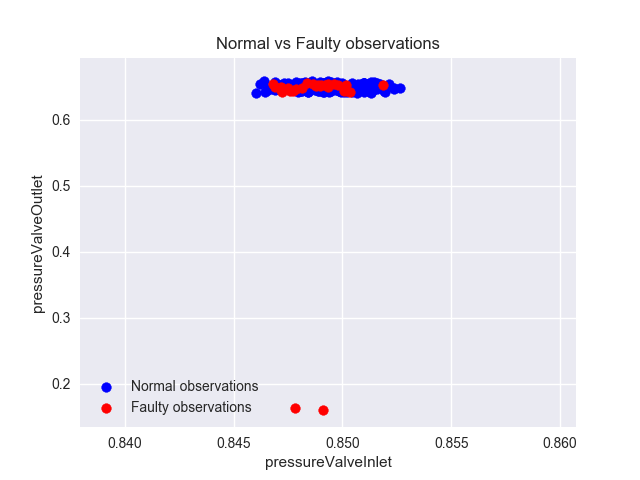

(100, 10)


<IPython.core.display.Javascript object>


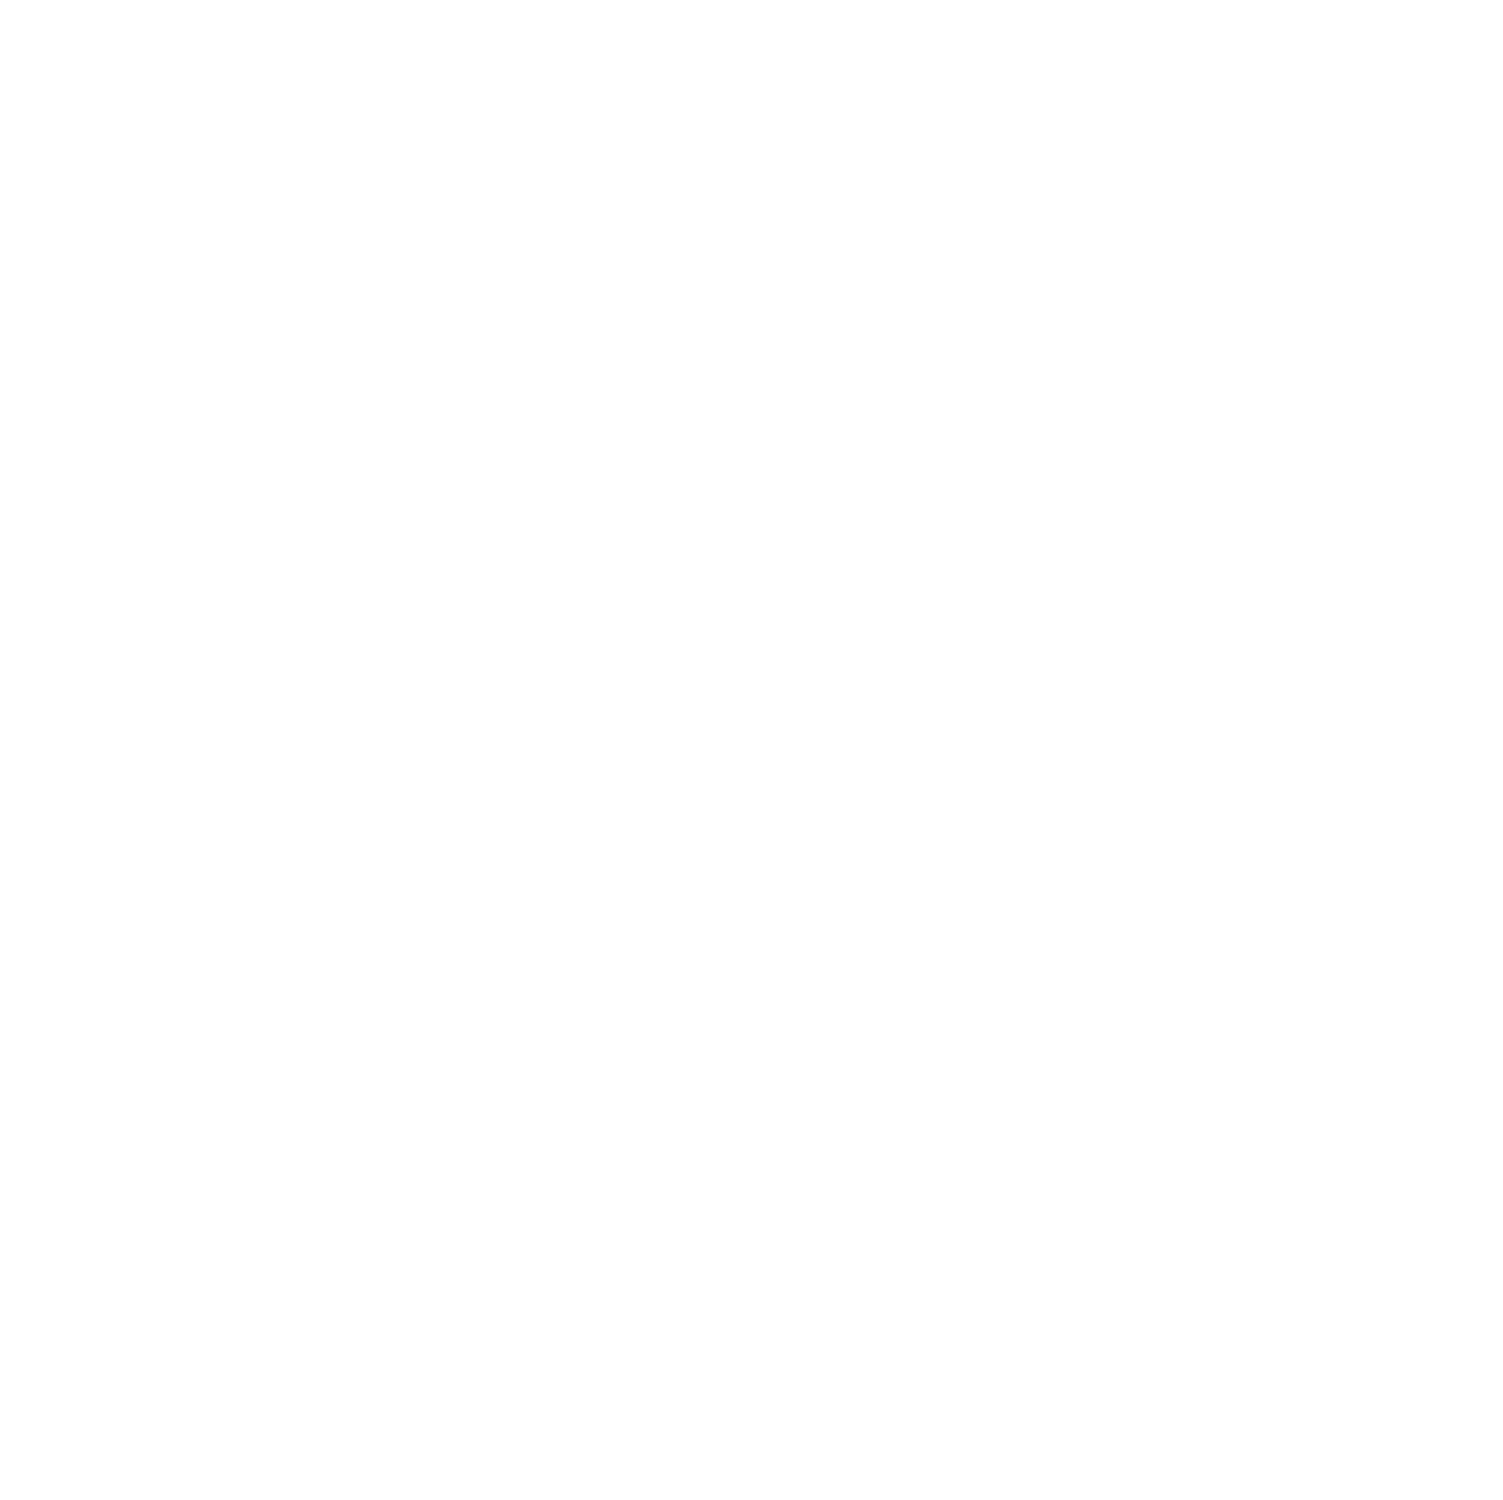

In [5]:
jplot_vars = ['externalControllerOutput', 'disturbedMediumFlow', 'pressureValveInlet', 'pressureValveOutlet', 
              'mediumTemperature', 'rodDisplacement']

df_sp = df[['pressureValveInlet', 'pressureValveOutlet', 'selectedFault']]
plottingTools.scatterplot_fault(df_sp, "Normal vs Faulty observations", nsamples = 200)

df_jp = df
df_jp.loc[df_jp['selectedFault'] != 20, 'selectedFault'] = 1
df_jp.loc[df_jp['selectedFault'] == 20, 'selectedFault'] = 0

plottingTools.jp_plotData(df_jp, "Joint plot", hue='selectedFault', saveToFile='damadicsPairPlot.png', vars = jplot_vars)

In [9]:
y_train_elliptic = y_train
y_test_elliptic = y_test
y_train_elliptic[y_train_elliptic == 0] = -1
y_test_elliptic[y_test_elliptic == 0] = -1
y_trains['EllipticEnvelope'] = y_train_elliptic
y_tests['EllipticEnvelope'] = y_test_elliptic

logger.info('Performing cross validations')

#print(X_train.shape)
#print(y_train.shape)

for classifierKey in classifiers:
    
    print('\nResults for {} classifier'.format(classifierKey))
    
    clf = classifiers[classifierKey]
    
    if y_trains[classifierKey] is not None:
        y_train = y_trains[classifierKey]
        
    cv_scores = cross_validate(clf, X_train, y_train[:,0], scoring=scoringMetrics, cv=cv_folds, return_train_score=True)
        
    print('{}-fold cross validation'.format(cv_folds))
        
    for key in cv_scores:
        print("For metric %s Accuracy: %0.5f (+/- %0.5f)" % (key, cv_scores[key].mean(), cv_scores[key].std() * 2))
    #print('Total sample size {}, Train Size {}, Test Size {}'.format(X_raw.shape[0], X_train.shape[0], X_test.shape[0]))'''

INFO:damadics:Performing cross validations



Results for DummyClf classifier
4-fold cross validation
For metric fit_time Accuracy: 0.00191 (+/- 0.00174)
For metric score_time Accuracy: 0.00710 (+/- 0.00338)
For metric test_precision_macro Accuracy: 0.49779 (+/- 0.00584)
For metric train_precision_macro Accuracy: 0.49938 (+/- 0.00407)
For metric test_recall_macro Accuracy: 0.50192 (+/- 0.00420)
For metric train_recall_macro Accuracy: 0.49859 (+/- 0.00330)
For metric test_f1_macro Accuracy: 0.49558 (+/- 0.01581)
For metric train_f1_macro Accuracy: 0.49822 (+/- 0.00508)

Results for EllipticEnvelope classifier
4-fold cross validation
For metric fit_time Accuracy: 14.33567 (+/- 1.72971)
For metric score_time Accuracy: 0.00907 (+/- 0.00094)
For metric test_precision_macro Accuracy: 0.47991 (+/- 0.14273)
For metric train_precision_macro Accuracy: 0.48014 (+/- 0.14452)
For metric test_recall_macro Accuracy: 0.47481 (+/- 0.17823)
For metric train_recall_macro Accuracy: 0.47567 (+/- 0.17923)
For metric test_f1_macro Accuracy: 0.27811 (+/